# Data curation for the LTKB dataset

Author: Tim Dudgeon (tdudgeon@informaticsmatters.com)
This notebook illustrates approaches to preparing a dataset for use in generating predictive models.
It uses the LTKB dataset from the FDA. __TODO__: specify the source of this.

This dataset contains a significant number of "unfriendly" molecules, some that are proteins and so do not have a SMILES string specified, some that are huge in size, and some that have salts present. This makes it necessary to clean up the data and create a sub-set that is suitable as input for machine learning. 

In [78]:
from IPython.display import Image
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import Image

In [79]:
from rdkit.Chem import PandasTools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
PandasTools.molRepresentation='svg'

In [80]:
# read the data from the CSV file
df = pd.read_csv('ltkb.csv', sep=',')
df.dtypes

LTKBID                             object
PubChem_CID                       float64
LabelCompoundName                  object
ApprovalYear                      float64
DILIConcern                        object
SeverityClass                       int64
LabelSection                       object
AdjudicatedDILI                    object
vDILIConcern                       object
Greene_Annotation                  object
Sakatis_Annotation                 object
Xu_Annotation                      object
Zhu_Annotation                     object
SMILES                             object
URL (accessed on 1/21/2016)        object
VER_DISP (1=LTKB-BD, 2=others)      int64
dtype: object

In [81]:
# remove unnecessary columns and provide better column names
df.drop('URL (accessed on 1/21/2016)', axis=1, inplace=True)
df.rename({'VER_DISP (1=LTKB-BD, 2=others)':'VER_DISP'}, axis='columns', inplace=True)
df.dropna(subset=['SMILES', 'LTKBID'], how='any', inplace=True)

In [82]:
# The 2 DILI columns are inconsistent in how they specify their columns.
# To fix this we convert the values to upper case.
df['DILIConcern'] = df['DILIConcern'].apply(lambda s: s.upper())
df['vDILIConcern'] = df['vDILIConcern'].apply(lambda s: s.upper())
df.dtypes

LTKBID                 object
PubChem_CID           float64
LabelCompoundName      object
ApprovalYear          float64
DILIConcern            object
SeverityClass           int64
LabelSection           object
AdjudicatedDILI        object
vDILIConcern           object
Greene_Annotation      object
Sakatis_Annotation     object
Xu_Annotation          object
Zhu_Annotation         object
SMILES                 object
VER_DISP                int64
dtype: object

In [83]:
df.head()

,LTKBID,PubChem_CID,LabelCompoundName,ApprovalYear,DILIConcern,SeverityClass,LabelSection,AdjudicatedDILI,vDILIConcern,Greene_Annotation,Sakatis_Annotation,Xu_Annotation,Zhu_Annotation,SMILES,VER_DISP
0,LT01185,5361919.0,ceftriaxone,1984.0,LESS-DILI-CONCERN,4,Adverse reactions,Yes,VLESS-DILI-CONCERN,HH,non-hepatotixic,Positive,Postive,CN1C(=NC(=O)C(=O)N1)SCC2=C(N3[C@@H]([C@@H](C3=O)NC(=O)/C(=N/OC)/C4=CSC(=N4)N)SC2)C(=O)O,2
1,LT01842,5578.0,trimethoprim,1980.0,LESS-DILI-CONCERN,4,Adverse reactions,Yes,VLESS-DILI-CONCERN,HH,non-hepatotixic,Positive,Postive,COC1=CC(=CC(=C1OC)OC)CC2=CN=C(N=C2N)N,2
2,LT00036,5353990.0,tetracycline,1953.0,LESS-DILI-CONCERN,2,Warnings and precautions,Yes,VLESS-DILI-CONCERN,HH,Hepatotoxic,Positive,Postive,CC1(C2CC3C(C(=O)/C(=C(\N)/O)/C(=O)C3(C(=O)C2=C(C4=C1C=CC=C4O)O)O)N(C)C)O,1
3,LT00289,2955.0,dapsone,1979.0,LESS-DILI-CONCERN,3,Warnings and precautions,Yes,VLESS-DILI-CONCERN,HH,Hepatotoxic,Positive,Postive,C1=CC(=CC=C1N)S(=O)(=O)C2=CC=C(C=C2)N,2
4,LT00166,1046.0,pyrazinamide,1971.0,LESS-DILI-CONCERN,3,Warnings and precautions,Yes,VLESS-DILI-CONCERN,HH,Hepatotoxic,Positive,Postive,C1=CN=C(C=N1)C(=O)N,1


In [84]:
df.shape

(960, 15)

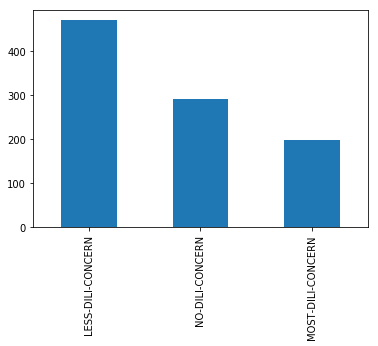

In [85]:
# examine the DILIConcern data
plt.figure();
df['DILIConcern'].value_counts().plot(kind='bar')

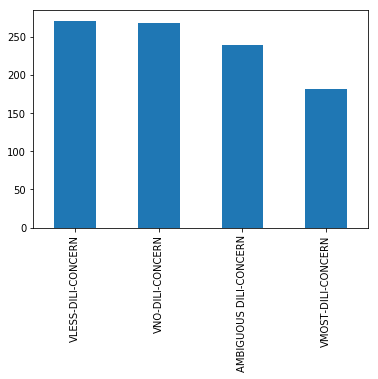

In [86]:
# examine the vDILIConcern data
plt.figure();
df['vDILIConcern'].value_counts().plot(kind='bar')

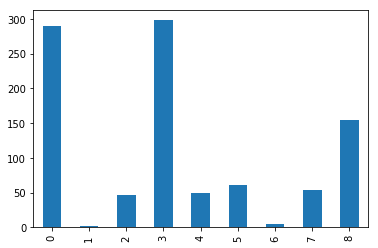

In [87]:
# examine the SeverityClass data
plt.figure();
df['SeverityClass'].value_counts(sort=False).plot(kind='bar')

These molecules are pretty nasty. They have multiple fragments, and some of them are huge. 
We need to clean this up, so start by standardizing the molecucles. This converts them into a "standard" representation, selects the biggest fragment (e.g. removes counter ions and solvents) and neutralises the molecule. 

In [88]:
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import RDLogger

# the standarizer currently spits out tons of output on STDOUT so we'll turn logging off for the moment
RDLogger.logger().setLevel(RDLogger.ERROR)

uncharger = rdMolStandardize.Uncharger()

# define the standardize function
def standardize(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mol = rdMolStandardize.FragmentParent(mol)
        mol = uncharger.uncharge(mol)
    return mol

# apply standardization and add the molecules to the data frame
df['MOL'] = df['SMILES'].apply(standardize)

## and revert logging back to normal
RDLogger.logger().setLevel(RDLogger.INFO)

In [89]:
# create categories
df2 = df.astype({
    'DILIConcern':'category',
    'SeverityClass':'category',
    'LabelSection':'category',
    'AdjudicatedDILI':'category',
    'vDILIConcern':'category',
    'Greene_Annotation':'category',
    'Sakatis_Annotation':'category',
    'Xu_Annotation':'category',
    'Zhu_Annotation':'category',
    'VER_DISP':'category'
    })
df2.dtypes

LTKBID                  object
PubChem_CID            float64
LabelCompoundName       object
ApprovalYear           float64
DILIConcern           category
SeverityClass         category
LabelSection          category
AdjudicatedDILI       category
vDILIConcern          category
Greene_Annotation     category
Sakatis_Annotation    category
Xu_Annotation         category
Zhu_Annotation        category
SMILES                  object
VER_DISP              category
MOL                     object
dtype: object

Let's inspect the data now. We have a wide range of types of molecules here and it will be best to focus on the main corpus of data and exclude the very quirky molecules as they will not be useful for predictions. 
We'll take a 'drug-likeness' perspective to this, so let's starrt by examining the size of the molecules (as indicated by the heavy atom count) and the cLogP. Also let's count the number of fragments to check that they all have just one now.

In [90]:
# calculate LogP, heavy atom count and number of fragments
from rdkit.Chem import Descriptors
df2['LOGP'] = df2['MOL'].apply(lambda mol: Descriptors.MolLogP(mol))
df2['HAC'] = df2['MOL'].apply(lambda mol: Descriptors.HeavyAtomCount(mol))
df2['FRAGS'] =  df2['MOL'].apply(lambda mol: len(Chem.GetMolFrags(mol,asMols=True)))

<Figure size 432x288 with 0 Axes>

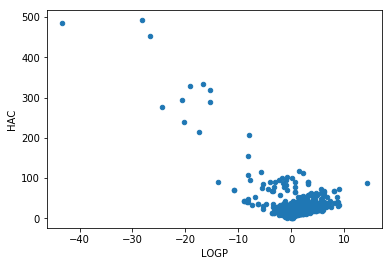

In [91]:
plt.figure();
df2.plot.scatter(x='LOGP', y='HAC');

So we have a small number of very large molecules and a small number of molecules with very low cLogP values. Mostly these are the same molecules. Let's look at them.
Playing around with the filters a bit we conclude that we shoudl exclude mols with a LogP < 14 and HAC > 200.

In [92]:
nastyMols = df2[df2['LOGP'] < -14]
nastyMols = nastyMols[nastyMols['HAC'] > 200]
nastyMols.shape

(11, 19)

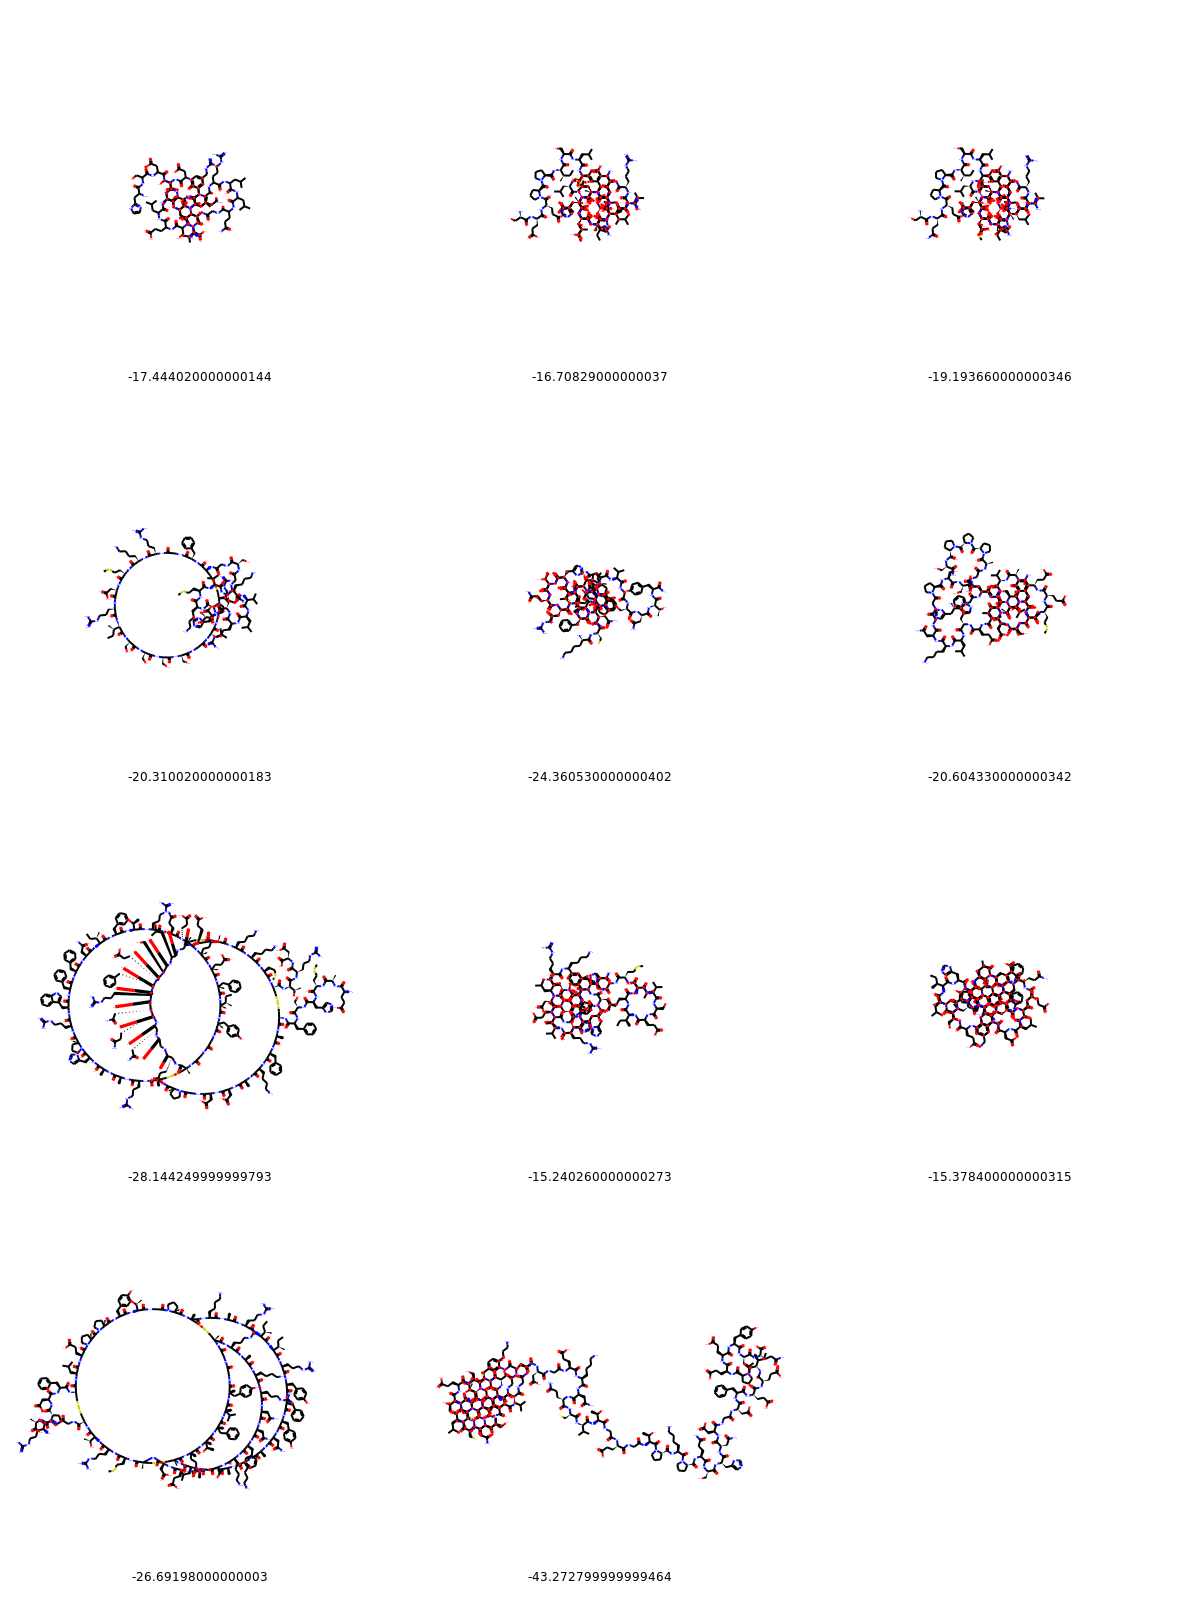

In [93]:
PandasTools.FrameToGridImage(nastyMols, column='MOL', legendsCol='LOGP', molsPerRow=3, subImgSize=(400, 400))

In [94]:
# so let's exclude those monsters and get only the nice mols
niceMols = df2[df2['LOGP'] >= -14]
niceMols = niceMols[niceMols['HAC'] <= 200]
niceMols.shape

(948, 19)

/opt/conda/lib/python3.6/site-packages/rdkit/Chem/Draw/IPythonConsole.py:183: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


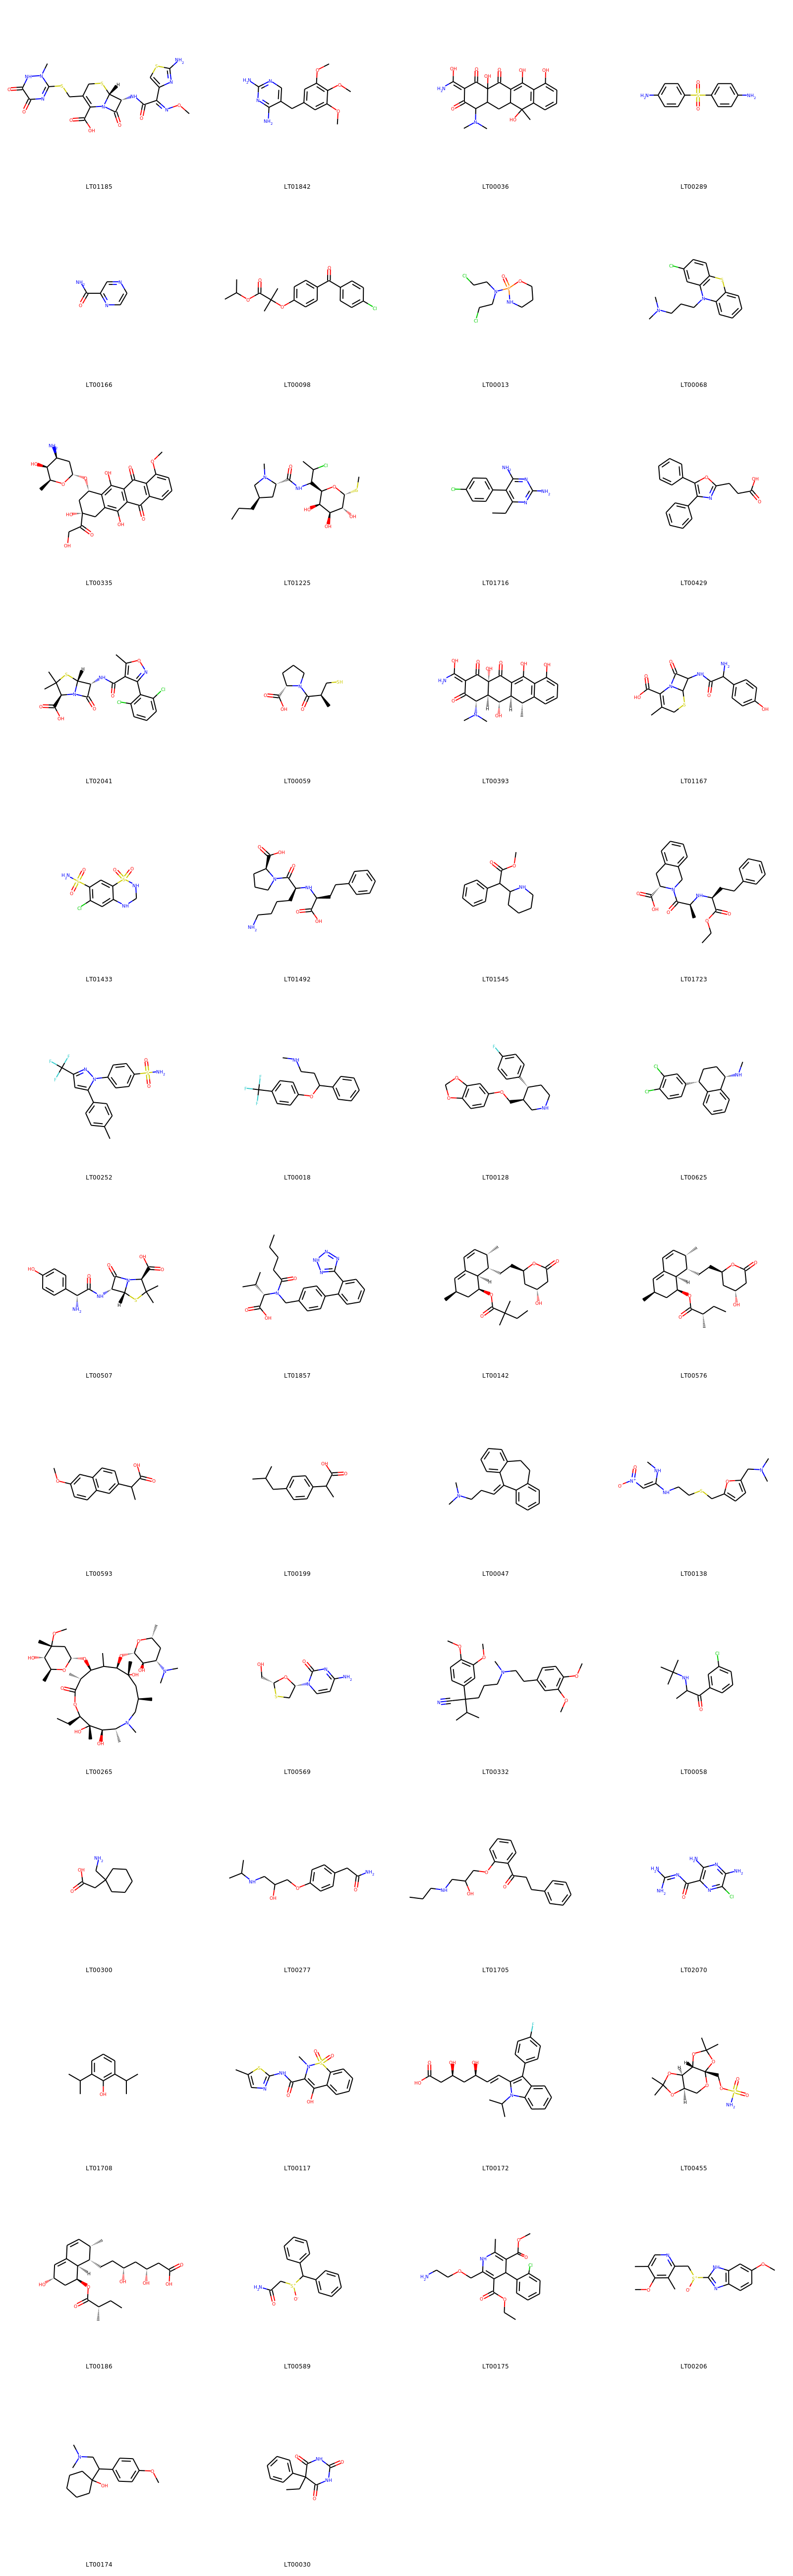

In [95]:
PandasTools.FrameToGridImage(niceMols, column='MOL', legendsCol='LTKBID', molsPerRow=4, subImgSize=(400, 400))

<Figure size 432x288 with 0 Axes>

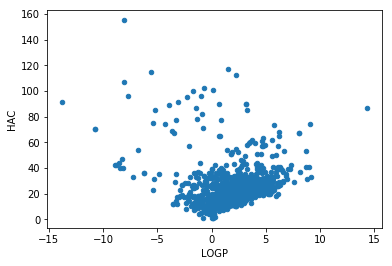

In [96]:
plt.figure();
niceMols.plot.scatter(x='LOGP', y='HAC');

Now generate Morgan2 and RDKit fingerprints that we can use for machine learning.

In [97]:
niceMols['RDK5'] = niceMols.MOL.apply(lambda mol: Chem.RDKFingerprint(mol, maxPath=5))
niceMols['MORGAN2'] = niceMols.MOL.apply(lambda mol: AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024))

In [98]:
# look at the Most DILI mols
mostDili = niceMols[niceMols['DILIConcern'] == 'MOST-DILI-CONCERN']
mostDili.shape

(198, 21)

These are the Most DILI molecules from our cleaned set.

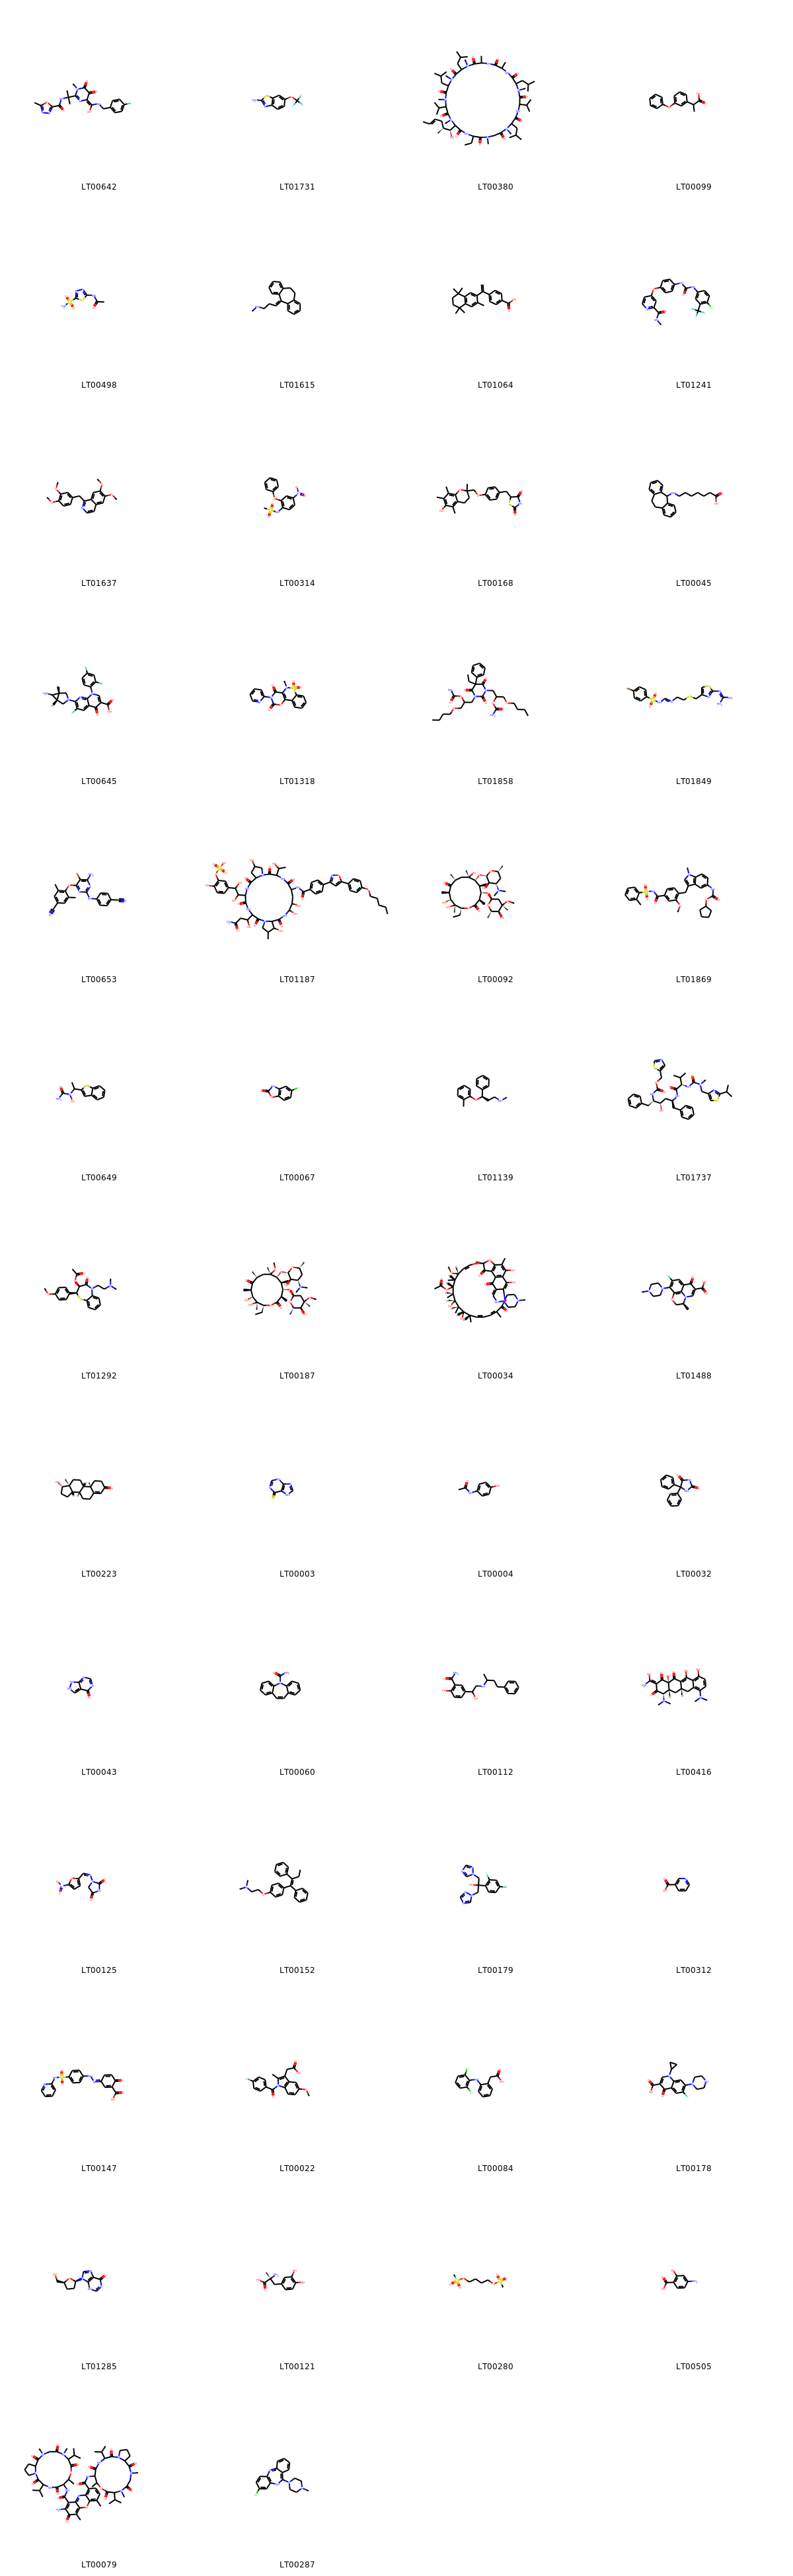

In [99]:
PandasTools.FrameToGridImage(mostDili, column='MOL', legendsCol='LTKBID', molsPerRow=4, subImgSize=(300, 300))